# Projet final Python For Data Analysis - CHASLE / CAZIER

## Librairies

In [246]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

In [2]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  cross_val_score

In [227]:
df_iranian_churn = pd.read_csv('./Customer Churn.csv', sep=',')

In [4]:
df_iranian_churn.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,FN,FP,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,177.8760,69.7640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,41.4315,60.0000,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,1382.8680,203.6520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,216.0180,74.0020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,131.2245,64.5805,0


In [5]:
df_iranian_churn.shape

(3150, 16)

In [228]:
df_iranian_churn.rename(columns={'Call  Failure': 'Call Failure', 'Subscription  Length': 'Subscription Length','Charge  Amount': 'Charge Amount'}, inplace=True)

In [229]:
del df_iranian_churn["FP"]
del df_iranian_churn["FN"]

On a supprimé les colonnes FN et FP

In [8]:
df_iranian_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call Failure             3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription Length      3150 non-null   int64  
 3   Charge Amount            3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

### Vérification s'il existe des valeurs NULL présents dans le dataset

In [9]:
nb_null_colonne = df_iranian_churn.isnull().sum()
nb_null_colonne

Call Failure               0
Complains                  0
Subscription Length        0
Charge Amount              0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64

<strong>Il n'y a pas de valeurs manquantes dans le dataset donc il n'y pas besoin de gérer les valeurs null</strong>

<h2 id="pattern_visualization">Analyzing Individual Feature Patterns using Visualization</h2>

When visualizing individual variables, it is important to first understand what type of variable you are dealing with. This will help us find the right visualization method for that variable.

In [10]:
print(df_iranian_churn.dtypes)

Call Failure                 int64
Complains                    int64
Subscription Length          int64
Charge Amount                int64
Seconds of Use               int64
Frequency of use             int64
Frequency of SMS             int64
Distinct Called Numbers      int64
Age Group                    int64
Tariff Plan                  int64
Status                       int64
Age                          int64
Customer Value             float64
Churn                        int64
dtype: object


Correlation matrix in order to see which features are correlated to the label 'Churn'

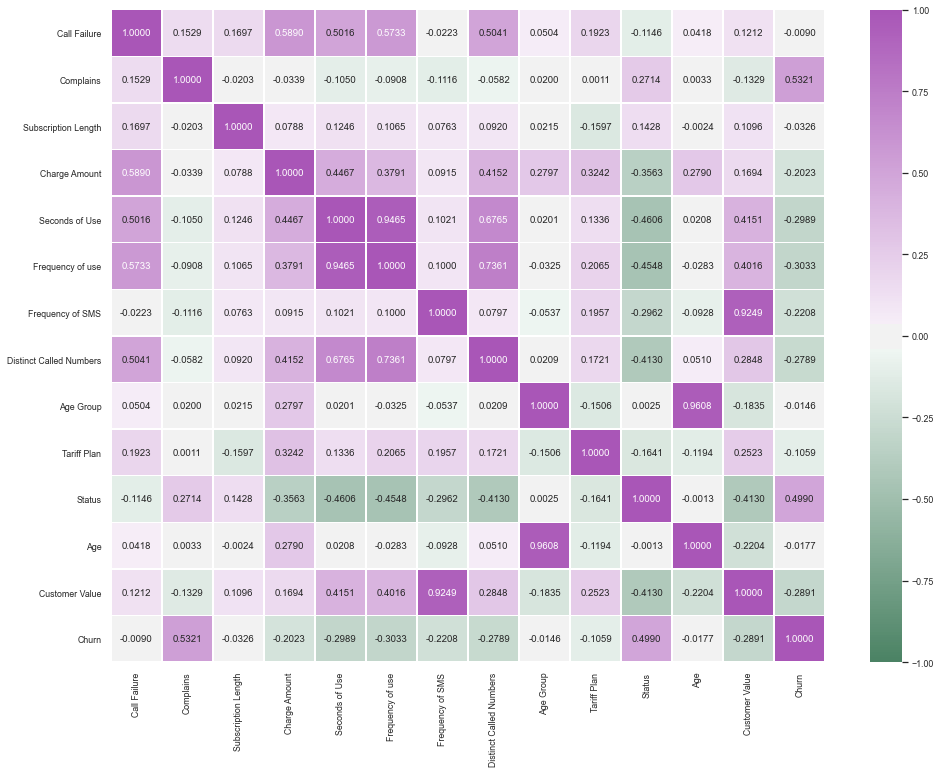

In [244]:
df_corr = df_iranian_churn.corr()

sns.set(font_scale=0.8)
plt.figure(figsize=(16,12))
sns.heatmap(df_corr, annot=True, fmt=".4f",vmin=-1, vmax=1, linewidths=.5, cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True))

plt.show()

PPscore alternative of Matrix Correlation with colors

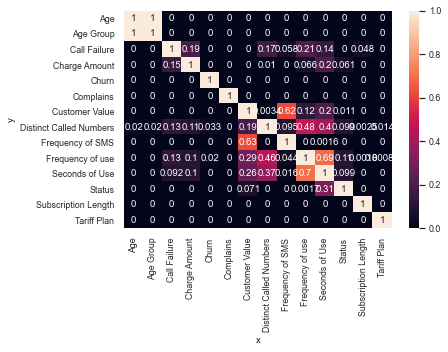

In [247]:
matrix_df = pps.matrix(df_iranian_churn).pivot(columns='x', index='y',  values='ppscore')

sns.heatmap(matrix_df, annot=True)

The PPS is an asymmetric, data-type-agnostic score that can detect linear or non-linear relationships between two columns. The score ranges from 0 (no predictive power) to 1 (perfect predictive power). It can be used as an alternative to the correlation (matrix).

A score of 0 means that the column x cannot predict the column y better than a naive baseline model.

A score of 1 means that the column x can perfectly predict the column y given the model.

A score between 0 and 1 states the ratio of how much potential predictive power the model achieved compared to the baseline model.

Correlation with the Age, Subscription Length, Complains, Frequency of use, charge amount

In [14]:
df_iranian_churn[['Age','Complains','Subscription Length','Charge Amount']].corr()

,Age,Complains,Subscription Length,Charge Amount
Age,1.000000,0.003298,-0.002430,0.278955
Complains,0.003298,1.000000,-0.020286,-0.033948
Subscription Length,-0.002430,-0.020286,1.000000,0.078789
Charge Amount,0.278955,-0.033948,0.078789,1.000000


These are variables that describe a 'characteristic' of a data unit, and are selected from a small group of categories. The categorical variables can have the type "object" or "int64". A good way to visualize categorical variables is by using boxplots.

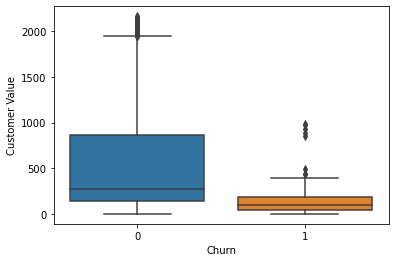

In [15]:
sns.boxplot(x="Churn", y="Customer Value", data=df_iranian_churn)

On peut déduire de ce graphe que si un client a une valeur auprès de la compagnie télécom de moins de 250 alors il y a de forte chances qu'il résilie son abonnement.
Donc plus le "customer_value" est faible, plus la probabilité que le client reste est faible.

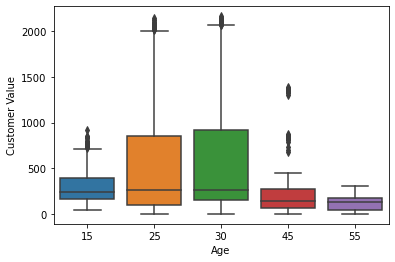

In [16]:
sns.boxplot(x="Age", y="Customer Value", data=df_iranian_churn)

On remarque dans la tranche d'âge 15-30, on a les clients avec une valeur clientèle forte auprès de l'opérateur dû probablement à une utilisation fréquente du réseau téléphonique.

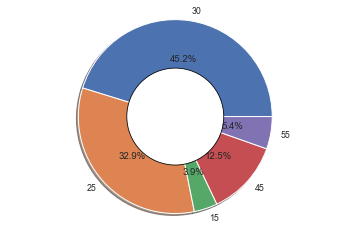

In [248]:
names=list(df_iranian_churn["Age"].unique())
sizes=[df_iranian_churn["Age"].value_counts()[unique_class]*100/len(df_iranian_churn["Age"]) for unique_class in names]
explode = (0, 0, 0, 0, 0)  # explode a slice if required

plt.pie(sizes, explode=explode, labels=names,
        autopct='%1.1f%%', shadow=True)
        
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0), 0.50, color='black', fc='white',linewidth=0.80)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

78.1% des utilisateurs ont entre 25 et 30 ans. Et auprès de l'opérateur, ces clients semblent la cible avisée afin d'augmenter le profil de l'entreprise.

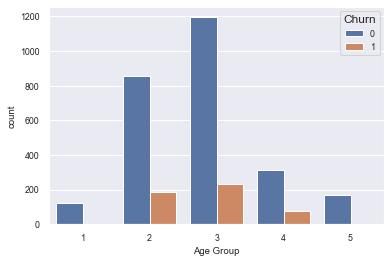

In [249]:
sns.countplot(x="Age Group", data=df_iranian_churn, hue="Churn")

On peut constater que la majorité des résiliations se font sur les tranches moyennes d'âge.

## Descriptive Statistical Analysis

In [17]:
df_iranian_churn.describe(include=['int'])

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,1.077778,1.248254,30.998413,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,8.831095,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,1.000000,1.000000,25.000000,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,1.000000,1.000000,30.000000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,1.000000,1.000000,30.000000,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,2.000000,2.000000,55.000000,1.000000


Variable de type float

In [18]:
df_iranian_churn.describe(include=['float'])

,Customer Value
count,3150.000000
mean,470.972916
std,517.015433
min,0.000000
25%,113.801250
50%,228.480000
75%,788.388750
max,2165.280000


In [19]:
# Call Failure as variable
Call_failure_counts = df_iranian_churn['Call Failure'].value_counts().to_frame()
Call_failure_counts.rename(columns={'Call Failure': 'value_counts'}, inplace=True)
Call_failure_counts.index.name = 'Call Failure'
Call_failure_counts.sort_values(by='Call Failure').head(10)

,value_counts
Call Failure,
0,702
1,121
2,137
3,141
4,133
5,244
6,161
7,166
8,156


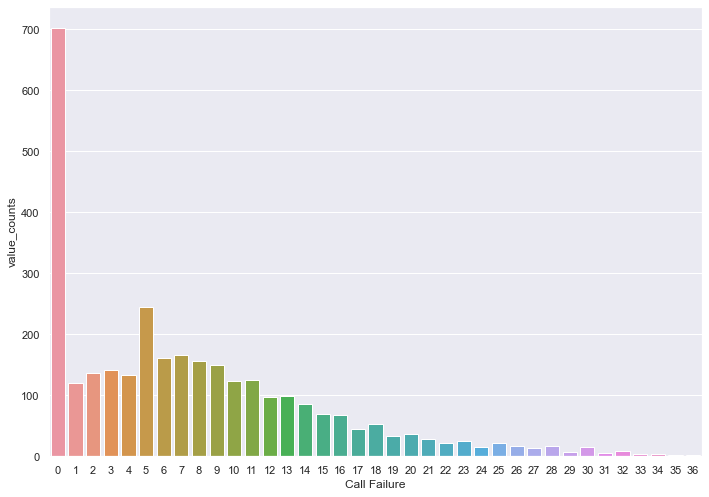

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=Call_failure_counts.index, y=Call_failure_counts['value_counts'])

Ce graphique représente le nombre de clients en fonction du nombre d'appels manqués (Coupure d'appel). On peut en déduire que le réseau de l'opérateur semble assez bien fonctionné 

In [85]:
# Call Failure as variable
Call_failure_counts = df_iranian_churn['Subscription Length'].value_counts().to_frame()
Call_failure_counts.rename(columns={'Subscription Length': 'value_counts'}, inplace=True)
Call_failure_counts.index.name = 'Subscription Length'
Call_failure_counts.sort_values(by='Subscription Length').head(10)

,value_counts
Subscription Length,
3,8
4,4
5,6
6,8
7,19
8,12
9,22
10,16
11,26


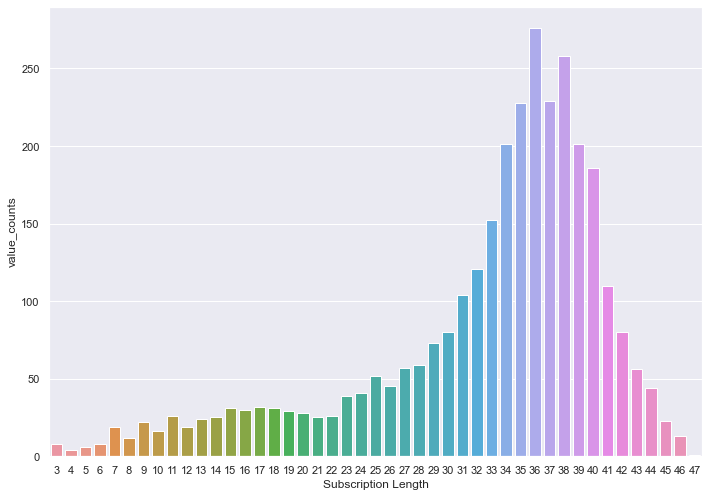

In [86]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=Call_failure_counts.index, y=Call_failure_counts['value_counts'])

Le nombre de clients en fonction de la durée d'abonnement depuis sa souscription.
On peut apercevoir que il y a peu de nouveaux abonnés qui ont souscrit récemment.
En moyenne la durée de l'abonnement des clients en majorité à partir de la souscription d'un abonnement téléphonique est entre 2 ans et 3 ans et demi. Il y a peu de clients qui ont un abonnement de plus de 4 ans. 

Ratio of Churn in the datasets

In [87]:
Churn_counts = df_iranian_churn['Churn'].value_counts().to_frame()
Churn_counts.rename(columns={'Churn': 'Ratio'}, inplace=True)
Churn_counts.index.name = 'Churn'
# Print the ratio of fraud cases
ratio_cases = Churn_counts/len(df_iranian_churn.index)
print(f'Ratio of Churn cases: {ratio_cases.loc[1]}\nRatio of non-Churn cases: {ratio_cases.loc[0]}')

Ratio of Churn cases: Ratio    0.157143
Name: 1, dtype: float64
Ratio of non-Churn cases: Ratio    0.842857
Name: 0, dtype: float64


Pourcentage des caractéristiques des personnes si elles ont résiliés ou non

Text(0.5, 1.0, 'Ratio of Churn Cases')

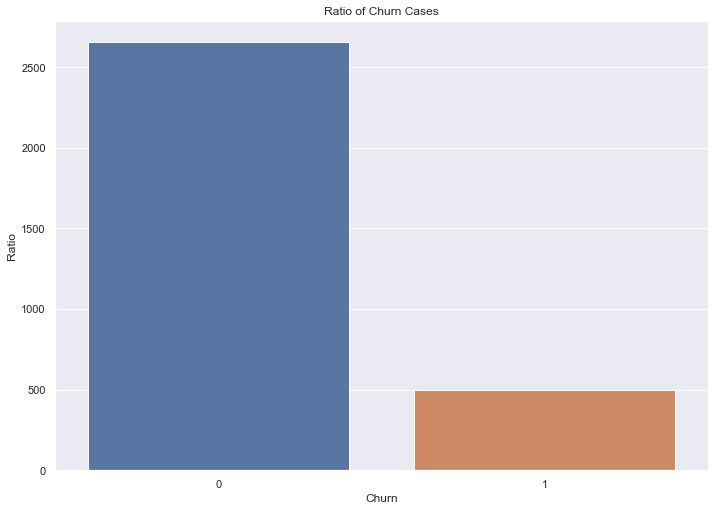

In [88]:
churn_graph = sns.barplot(x=Churn_counts.index, y=Churn_counts['Ratio'])
churn_graph.set_title("Ratio of Churn Cases")

On peut s'apercevoir que l'opérateur a un bon ratio de clients Résiliés / non-Résiliés. 

In [89]:
df_group_one = df_iranian_churn[['Customer Value','Status', 'Frequency of SMS', 'Age', 'Frequency of use', 'Age Group', 'Complains', 'Tariff Plan', 'Call Failure','Churn', 'Subscription Length', 'Charge Amount', 'Seconds of Use', 'Distinct Called Numbers']].groupby(['Churn']).mean()
df_group_one

,Customer Value,Status,Frequency of SMS,Age,Frequency of use,Age Group,Complains,Tariff Plan,Call Failure,Subscription Length,Charge Amount,Seconds of Use,Distinct Called Numbers
Churn,,,,,,,,,,,,,
0,535.511501,1.155179,83.871563,31.065913,76.979284,2.831638,0.015443,1.090019,7.656121,32.662524,1.075706,5014.224105,25.582674
1,124.811414,1.747475,15.802020,30.636364,29.133333,2.795960,0.404040,1.012121,7.476768,31.894949,0.230303,1566.632323,12.391919


In [90]:
df_group_two = df_iranian_churn[['Customer Value','Status', 'Frequency of SMS', 'Age', 'Frequency of use', 'Age Group', 'Complains', 'Tariff Plan', 'Call Failure','Churn', 'Subscription Length', 'Charge Amount', 'Seconds of Use', 'Distinct Called Numbers']]
df_group_two

,Customer Value,Status,Frequency of SMS,Age,Frequency of use,Age Group,Complains,Tariff Plan,Call Failure,Churn,Subscription Length,Charge Amount,Seconds of Use,Distinct Called Numbers
0,197.640,1,5,30,71,3,0,1,8,0,38,0,4370,17
1,46.035,2,7,25,5,2,0,1,0,0,39,0,318,4
2,1536.520,1,359,30,60,3,0,1,10,0,37,0,2453,24
3,240.020,1,1,15,66,1,0,1,10,0,38,0,4198,35
4,145.805,1,2,15,58,1,0,1,3,0,38,0,2393,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,721.980,1,92,25,147,2,0,2,21,0,19,2,6697,44
3146,261.210,1,80,55,177,5,0,1,17,0,17,1,9237,42
3147,280.320,1,38,30,51,3,0,1,13,0,18,4,3157,21
3148,1077.640,1,222,30,46,3,0,1,7,0,11,2,4695,12


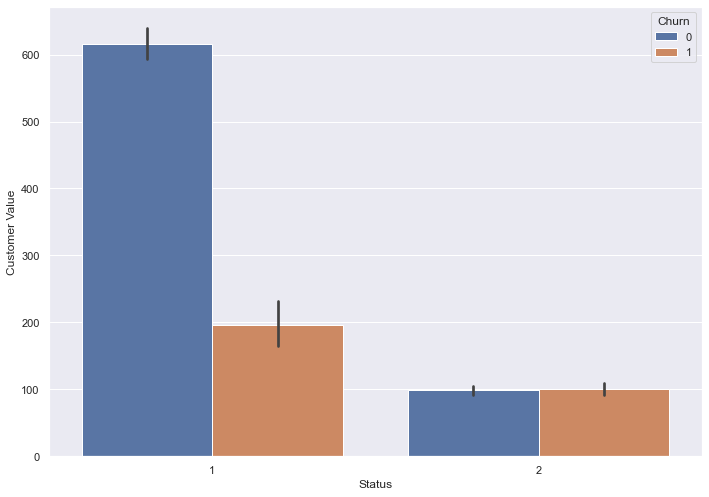

In [91]:
sns.barplot(data=df_group_two, x='Status', y='Customer Value', hue="Churn")

Le statut représente l'état d'un client. Si il est actif alors le statut est un 1 et 2 dans le cas contraire. On peut remarquer que un client non actif incite fortement sur une résiliation de son abonnement.

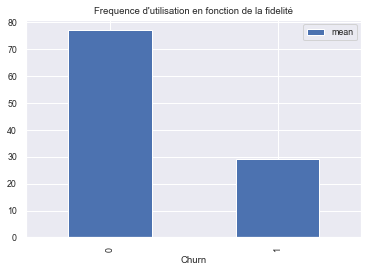

In [253]:
grouped = df_iranian_churn.groupby(["Churn"])["Frequency of use"]
grouped.agg(["mean"]).plot.bar(title="Frequence d'utilisation en fonction de la fidelité")

On peut remarquer que la fréquence d'utilisation du réseau téléphonique est plus grande chez les personnes qui ne résilient pas. Cela pourrait être un paramètre qui joue sur la résiliation d'un abonnement.

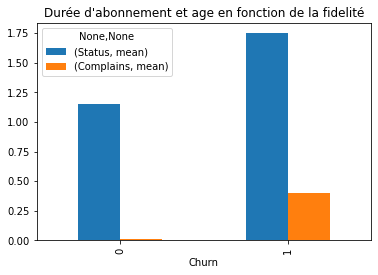

In [243]:
grouped = df_iranian_churn.groupby(["Churn"])[["Status", "Complains"]]
grouped.agg(["mean"]).plot.bar(title="Durée d'abonnement et age en fonction de la fidelité")

On remarque que en moyenne, les personnes ayant résiliés sont en moyenne moins actifs que les non-résiliés et se plaignent plus souvent que auprès de la compagnie téléphonique

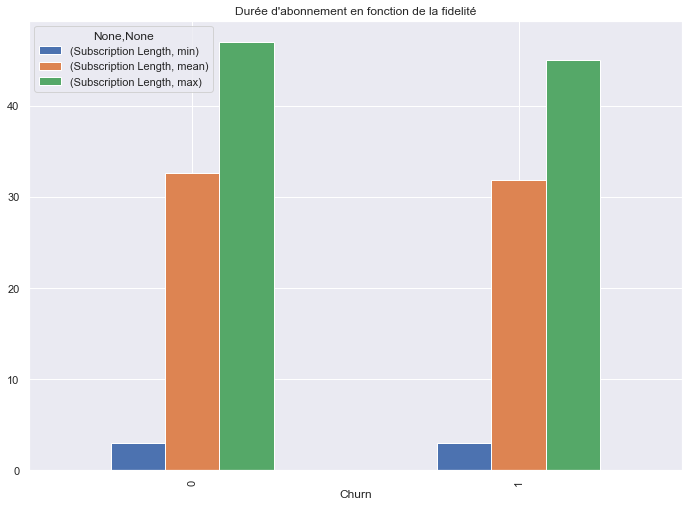

In [94]:
grouped = df_iranian_churn.groupby(["Churn"])[["Subscription Length"]]
grouped.agg(["min", "mean", "max"]).plot.bar(title="Durée d'abonnement en fonction de la fidelité")

Pas de différence entre les abonnées et résiliés en age et en durée d'abonnement

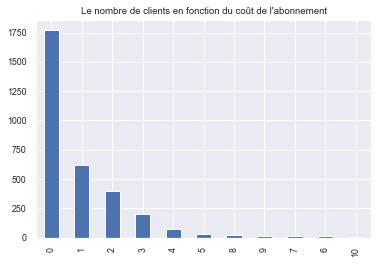

In [256]:
nombre_quantite_charges = df_iranian_churn["Charge Amount"].value_counts()
nombre_quantite_charges.plot.bar(title="Le nombre de clients en fonction du coût de l'abonnement")

On peut constater que les clients prennent les forfaits les moins chers ce qui est logique.

In [96]:
nombre_quantite_total = len(df_iranian_churn["Complains"])
list_complains = [y/nombre_quantite_total for y in df_iranian_churn["Complains"].value_counts()]
X = pd.DataFrame({"Nombre total": list_complains})
X

,Nombre total
0,0.923492
1,0.076508


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe695e72e50>],
      dtype=object)

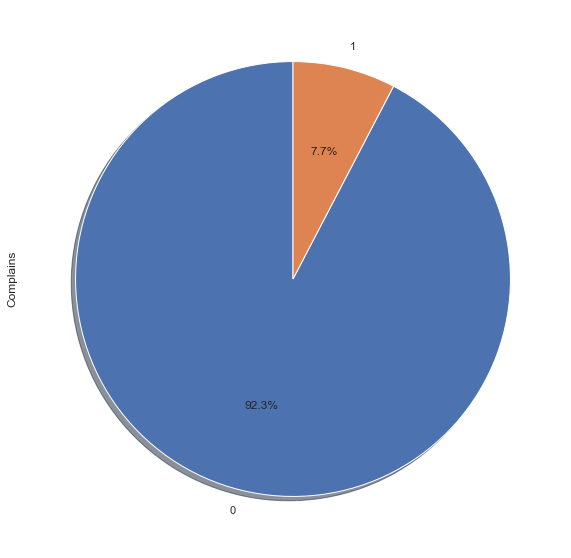

In [97]:
nombre_quantite_charges = df_iranian_churn["Complains"].value_counts()
nombre_quantite_charges.plot(kind='pie', subplots=True, shadow = True,startangle=90,
figsize=(15,10), autopct='%1.1f%%')

On peut s'apercevoir que le nombre de personnes qui se sont plaints est en minorité face aux clients satisfaits

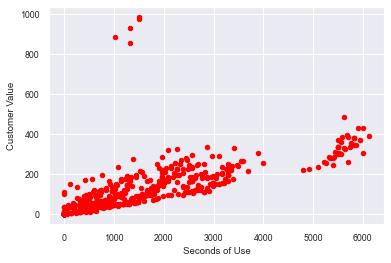

In [258]:
ax = df_iranian_churn[df_iranian_churn["Churn"] == 1].plot.scatter(x="Seconds of Use", y="Customer Value", color="red")


On peut s'apercevoir que globalement  les personnes ayant résiliés et ayant utilisés le plus longtemps le réseau ont un score plus élévé auprès de l'opérateur.

## Partie 2 : Modélisation (Machine Learning Algorithms)

### Fonctions Machine Learning

In [53]:
def print_time():
    """
    Affiche et retourne l'heure de la machine.
    Utilisé pour mesurer le temps d'execution du classifieur.
    """
    import time
    import datetime
    t = datetime.datetime.now().time()
    print(t.isoformat()[:8])
    return time.time()
print_time()

18:35:04


1610213704.0798872

In [54]:
def draw_roc_curve(fitted_c, x_test, y_test, title):
    """
    Créé et affiche la courbe ROC des données de test X et Y selon un classifieur (SVM, KNN, RF).
    Permet de représenter l'évolution de la vitesse d'apprentissage du classifieur.
    Taux de vrais-positifs en fonction du taux de faux-négatif.
    Plus l'aire sous la courbe est grande, plus le classifieur est idéal.
    """
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    c                                        = fitted_c
    probas                                   = c.predict_proba(x_test)
    false_positive_rate, recall_, thresholds = roc_curve(y_test, probas[:,1])
    roc_auc                                  = auc(false_positive_rate, recall_)
    
    plt.title  ('ROC %.2f %s'%(roc_auc, title))
    plt.legend (loc="lower right")
    plt.plot   ([0,1],[0,1], "r--")
    plt.plot   (false_positive_rate, recall_, 'b', label='AUC = %.2f'%roc_auc)
    plt.xlim   ([0.0,1.1])
    plt.ylim   ([0.0,1.1])
    plt.ylabel ('Recall')
    plt.xlabel ('Fall-out')
    plt.show()

In [223]:
def draw_confusion_matrix(y_test, predictions, title):
    """
    Créé et affiche la matrice de confusion des données de Y_test et de celles sur lesquelles on a fait la prédiction.
    Permet d'évaluer la qualité de la classification souhaitée.
    Plus les valeurs diagonales sont élevées, plus le classifieur prédit correctement.
    """
    from sklearn.metrics import confusion_matrix,accuracy_score
    import matplotlib.pyplot as plt
    cm    = confusion_matrix(y_test, predictions)
    accur = accuracy_score  (y_test, predictions)
    
    plt.matshow  (cm)
    plt.ylabel   ('True Label')
    plt.xlabel   ('Predicted Label')
    plt.suptitle ('Confusion matrix (Accuracy of %.2f) for [%s]'%(accur,title))
    plt.colorbar ()
    plt.show     ()

### Récupération des données + préprocessing

In [261]:
df_iranian_churn = pd.read_csv('./Customer Churn.csv', sep=',')
df_iranian_churn.rename(columns={'Call  Failure': 'Call Failure', 'Subscription  Length': 'Subscription Length','Charge  Amount': 'Charge Amount'}, inplace=True)
del df_iranian_churn["FP"]
del df_iranian_churn["FN"]

In [262]:
# X peut etre sous forme de dataframe ou numpy.ndarray
# Y peut etre sous forme de series ou numpy.ndarray
X = df_iranian_churn.iloc[:, 0:14]
y = df_iranian_churn['Churn']
X.drop(['Churn'], axis=1, inplace=True)
X.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805


## Algorithmes Machine Learning

## Logistic Regression

In [263]:
 # Step 1: split the features and labels into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Step 2: Fit a logistic regression model to our data
model_LR = LogisticRegression(solver='liblinear')

 # Step 3: Fit the model to the training data
model_LR.fit(X_train, y_train)

 # Step 4: Obtain model predictions from the test data
predicted = model_LR.predict(X_test)

accuracy_score_LR = accuracy_score(y_test, predicted)
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted):0.3f}')

# Step 5: Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted)) 
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted) 
print('Confusion matrix:\n', conf_mat)

Accuracy Score:
0.895
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       538
           1       0.72      0.46      0.56        92

    accuracy                           0.90       630
   macro avg       0.82      0.71      0.75       630
weighted avg       0.89      0.90      0.88       630

Confusion matrix:
 [[522  16]
 [ 50  42]]


### Vérification de la véracité de la prédiction avec des valeurs de mon profil 

In [148]:
predicted = X_test.iloc[0,:]
predicted = model_LR.predict([[1,0, 60, 4, 8600, 78, 2233, 18, 2, 1, 1, 23, 1500.00]])
predicted

array([0])

### Vérification de la véracité de la prédiction avec des valeurs supposées influencer la résiliation

In [149]:
predicted = X_test.iloc[0,:]
predicted = model_LR.predict([[42, 1, 12, 8, 400, 20, 16, 4, 2, 1, 1, 2, 120.00]])
predicted

array([1])

On obtient bien comme résultat une résiliation du client avec les paramètres suivants :
    Call Failure = 42,
    Complains = 1,
    Subscription Length = 12,
    Charge Amount = 8,
    Seconds of Use = 400,
    Frequency of use = 20,
    Frequency of SMS = 16,
    Distinct Called Numbers = 4,
    Age Group = 2,
    Tariff Plan = 1,
    Status = 1,
    Age = 2,
    Customer Value = 120
    
Avec ces paramètres, ce résultat semble être cohérant et concorder avec la réalité

## Logistic regression with SMOTE

La classification déséquilibrée implique le développement de modèles prédictifs sur des ensembles de données de classification qui présentent un grave déséquilibre de classe.

Le défi de travailler avec des ensembles de données déséquilibrés est que la plupart des techniques d'apprentissage automatique ignorent la classe minoritaire et ont à leur tour de mauvaises performances sur cette classe, bien que ce soit généralement la performance sur la classe minoritaire qui est la plus importante.

Une approche pour remédier aux ensembles de données déséquilibrés consiste à suréchantillonner la classe minoritaire. L'approche la plus simple consiste à dupliquer des exemples dans la classe minoritaire, bien que ces exemples n'ajoutent aucune nouvelle information au modèle. Au lieu de cela, de nouveaux exemples peuvent être synthétisés à partir des exemples existants. Il s'agit d'un type d'augmentation des données pour la classe minoritaire, appelé "Synthetic Minority Oversampling Technique" (SMOTE).

In [264]:
""" Logistic regression with SMOTE """
# Define which resampling method and which ML model to use in the pipeline
resampling = SMOTE()
model_LR_SMOTE = LogisticRegression(solver='liblinear')

# Combining a logistic regression with a SMOTE method
# Treat Pipeline as if it was a single ml model
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model_LR_SMOTE)])

# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0 )

pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

accuracy_score_LR_SMOTE = accuracy_score(y_test, predicted)
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted):0.3f}')

# Obtain the results from the classification report and confusion matrix
print('Classifcation report:\n', classification_report(y_test, predicted)) 
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted) 
print('Confusion matrix:\n', conf_mat)

Accuracy Score:
0.837
Classifcation report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89       521
           1       0.52      0.91      0.66       109

    accuracy                           0.84       630
   macro avg       0.75      0.86      0.78       630
weighted avg       0.90      0.84      0.85       630

Confusion matrix:
 [[428  93]
 [ 10  99]]


Avec le SMOTE, la regression logistique a une précision plus faible pour le nombre de  clients ayant résiliés que celle sans. Le surechantillonage du nombre d'échantillons pour la classe 1 (le client résilie) a entrainé plus de FP qui est moins grave que d'avoir plus de FN. 

Par ailleurs, on constate qu'on a moins de FN ce qui est encourageant et on prédit mieux les personnes qui souhaitent résiliées avec cette méthode

## Random Forest

In [265]:
from inspect import signature 
""" RANDOM FOREST """

# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0 )

 # Define the model as the random forest
model_RF = RandomForestClassifier(random_state=5, min_samples_leaf=3, n_estimators=200, n_jobs=-1)

 # Fit the model to our training set
model_RF.fit(X_train, y_train)

 # Obtain predictions from the test data
predicted = model_RF.predict(X_test)

accuracy_score_RF = accuracy_score(y_test, predicted)
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted):0.3f}')
 
  # Predict probabilities
probs = model_RF.predict_proba(X_test)
# Print the ROC curve, classification report and confusion matrix
print('ROC Score:') 
print(roc_auc_score(y_test, probs[:,1])) 
print('\nClassification Report:') 
print(classification_report(y_test, predicted)) 
print('\nConfusion Matrix:') 
print(confusion_matrix(y_test, predicted))

Accuracy Score:
0.948
ROC Score:
0.9828487911391292

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       521
           1       0.89      0.80      0.84       109

    accuracy                           0.95       630
   macro avg       0.92      0.89      0.90       630
weighted avg       0.95      0.95      0.95       630


Confusion Matrix:
[[510  11]
 [ 22  87]]


Precision: [0.17883598 0.88356164 1.        ]
Recall: [1.         0.76331361 0.        ]


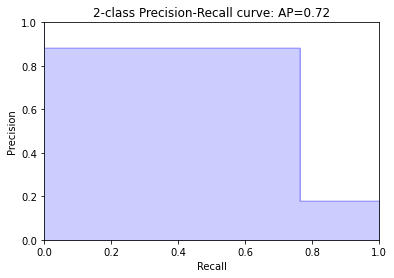

In [64]:
# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted) 
average_precision

# Obtain precision and recall
precision, recall, _ = precision_recall_curve(y_test, predicted) 
print(f'Precision: {precision}\nRecall: {recall}')

def plot_pr_curve(recall, precision, average_precision): 
    plt.figure()
    step_kwargs = ({'step': 'post'}
    if 'step' in signature(plt.fill_between).parameters else {})
    plt.step(recall, precision, color='b', alpha=0.2, where='post') 
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title(f'2-class Precision-Recall curve: AP={average_precision:0.2f}') 
    return plt.show()

 # Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

## KNN

In [266]:
from sklearn.neighbors         import KNeighborsClassifier
# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0 )

 # Define the model as the random forest
model_KNN = KNeighborsClassifier()

 # Fit the model to our training set
model_KNN.fit(X_train, y_train)

 # Obtain predictions from the test data
predicted = model_KNN.predict(X_test)

accuracy_score_KNN = accuracy_score(y_test, predicted)
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted):0.3f}')
 
  # Predict probabilities
probs = model_KNN.predict_proba(X_test)
# Print the ROC curve, classification report and confusion matrix
print('ROC Score:') 
print(roc_auc_score(y_test, probs[:,1])) 
print('\nClassification Report:') 
print(classification_report(y_test, predicted)) 
print('\nConfusion Matrix:') 
print(confusion_matrix(y_test, predicted))

Accuracy Score:
0.846
ROC Score:
0.8350208667171459

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       521
           1       0.57      0.42      0.49       109

    accuracy                           0.85       630
   macro avg       0.73      0.68      0.70       630
weighted avg       0.83      0.85      0.84       630


Confusion Matrix:
[[487  34]
 [ 63  46]]


## CLF 

In [267]:
from sklearn.ensemble import GradientBoostingClassifier
# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0 )

 # Define the model as the random forest
model_CLF = GradientBoostingClassifier()

 # Fit the model to our training set
model_CLF.fit(X_train, y_train)

 # Obtain predictions from the test data
predicted = model_CLF.predict(X_test)

accuracy_score_CLF = accuracy_score(y_test, predicted)
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted):0.3f}')

  # Predict probabilities
probs = model_KNN.predict_proba(X_test)
# Print the ROC curve, classification report and confusion matrix
print('ROC Score:') 
print(roc_auc_score(y_test, probs[:,1])) 
print('\nClassification Report:') 
print(classification_report(y_test, predicted)) 
print('\nConfusion Matrix:') 
print(confusion_matrix(y_test, predicted))

Accuracy Score:
0.940
ROC Score:
0.8350208667171459

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       521
           1       0.84      0.81      0.82       109

    accuracy                           0.94       630
   macro avg       0.90      0.89      0.89       630
weighted avg       0.94      0.94      0.94       630


Confusion Matrix:
[[504  17]
 [ 21  88]]


## Comparaison de tous les algorithmes

In [154]:
performances = {}
performances['Logistic Regression'] = [accuracy_score_LR]
performances['Logistic Regression with SMOTE'] = [accuracy_score_LR_SMOTE]
performances['Random Forest'] = [accuracy_score_RF]
performances['KNN'] = [accuracy_score_KNN]
performances['Classifier Grading Boosting'] = [accuracy_score_CLF]
performances

{'Logistic Regression': [0.9126984126984127],
 'Logistic Regression with SMOTE': [0.8201058201058201],
 'Random Forest': [0.946031746031746],
 'KNN': [0.8285714285714286],
 'Classifier Grading Boosting': [0.9343915343915344]}

In [155]:
df_performances = pd.DataFrame(performances).T
col_name = "Performance"
df_performances.columns = [col_name]
df_performances

,Performance
Logistic Regression,0.912698
Logistic Regression with SMOTE,0.820106
Random Forest,0.946032
KNN,0.828571
Classifier Grading Boosting,0.934392


## Classement des performances des algorithmes

In [156]:
df_performances["Performance"].sort_values()

Logistic Regression with SMOTE    0.820106
KNN                               0.828571
Logistic Regression               0.912698
Classifier Grading Boosting       0.934392
Random Forest                     0.946032
Name: Performance, dtype: float64

## Gain en performance (comparaison entre les algorithmes avec le premier du dataframe)

In [157]:
liste_des_performances = df_performances.Performance.values
gains = [0]
for indice, performance in enumerate(liste_des_performances):
    if indice>0:
        previous_value = liste_des_performances[indice-1]
        current_value  = liste_des_performances[indice]
        gain = (current_value - previous_value) / previous_value
        gains.append(round(gain*100, 2))
df_performances["gains"] = gains

In [158]:
df_performances

,Performance,gains
Logistic Regression,0.912698,0.00
Logistic Regression with SMOTE,0.820106,-10.14
Random Forest,0.946032,15.35
KNN,0.828571,-12.42
Classifier Grading Boosting,0.934392,12.77


## Visualisation des performances des algorithmes

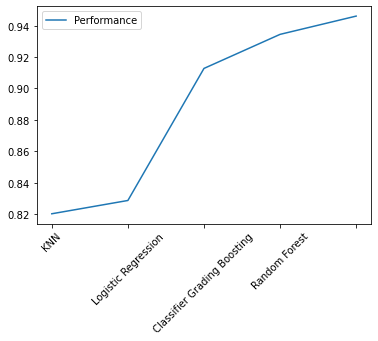

In [159]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
df_performances = df_performances.drop("gains", axis=1)
df_performances = df_performances.sort_values(col_name)
ax = df_performances.plot(rot=45, x_compat=True)
ax.xaxis.set_ticklabels(df_performances.index)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

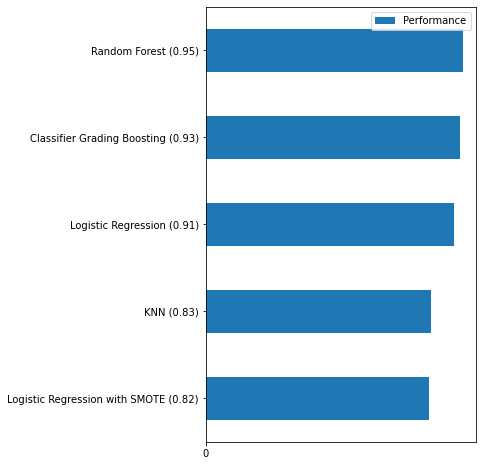

In [160]:
new_labels = []
for i, index in enumerate(df_performances.index):
    new_label = "%s (%.2f)"%(index,df_performances.Performance[i])
    new_labels.append(new_label.replace("\n", " "))
    
fig , axes = plt.subplots(1,1)
df_performances.index = new_labels
fig.set_size_inches(15,8)
fig.subplots_adjust(left=0.65)
df_performances.sort_values(col_name).plot(kind='barh', ax=axes)
axes.xaxis.set_major_locator(ticker.MultipleLocator(1))

pass

Le meilleur algorithme pour la classification dans notre étude est l'algorithme du random forest.

# Algorithmes avec grid Search

## Random Forest With Grid Search 

In [234]:
def RandomForest_grid_search(df, Y):
    """
    Réglage des hyper-paramètres du classifieur Random Forest
    """
    import sys, pickle
    from sklearn.ensemble          import RandomForestClassifier
    from sklearn.model_selection   import GridSearchCV
    from sklearn.metrics           import make_scorer
    from sklearn.preprocessing     import label_binarize
    from sklearn.multiclass        import OneVsRestClassifier
    #grid search :

    parameters = {  "n_estimators"         : [ 10, 100, 200 ], 
                    "min_samples_leaf"     : [  3,   1,   7 ],
                    "criterion"            : ["gini"],#["gini", "entropy"]         ,
                    "max_features"         : ["auto"]      ,
                    "max_depth"            : [None]         , 
                    "n_jobs"               : [ -1]             ,  
                    #"class_weight"         : ["auto"]          ,
                    "warm_start"           : [False]           }
    parameters = {  "n_estimators"         : [ 10], 
                    "min_samples_leaf"     : [  3 ],
                    "criterion"            : ["gini"],#["gini", "entropy"]         ,
                    "max_features"         : ["auto"]      ,
                    "max_depth"            : [None]         , 
                    "n_jobs"               : [ -1]             ,  
                    #"class_weight"         : ["auto"]          ,
                    "warm_start"           : [False]           }
    
    grid_type = "RandomForestClassifier"
    
    print ("-"*30, "\n %s"%grid_type); sys.stdout.flush()
    """
        Search 
    """
    
    # Exhaustive Grid Search : will try all parameters combinations
    # vs RandomizedSeachCV where the model test random combinations.
    
    grid         = GridSearchCV(RandomForestClassifier(), parameters, verbose=1, scoring='f1_weighted')
    
    try :grid.fit(df, Y)
    except Exception as e : print ("[%s - 2] : %s"%(grid_type,e) )
    
    print (" best_score_ %s with =  %s "%( grid.best_score_,  grid.best_estimator_ ) ); sys.stdout.flush()    
    return grid.best_estimator_

In [232]:
# La classification se fait en fonction de la variable 'churn' 
X_train, X_test, Y_train, Y_test = train_test_split(X, y)

In [235]:
nb_lignes = 3000
start_time = print_time()

# Apprentissage du classifieur RF sur X_train et Y_train (<nb_lignes> données)
rf = RandomForest_grid_search(X_train[:nb_lignes], Y_train[:nb_lignes])

end_time = print_time()
print ("\nDuration time :", end_time - start_time)

19:41:27
------------------------------ 
 RandomForestClassifier
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


 best_score_ 0.9471870834085843 with =  RandomForestClassifier(min_samples_leaf=3, n_estimators=10, n_jobs=-1) 
19:41:31

Duration time : 3.5310330390930176


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s finished


No handles with labels found to put in legend.


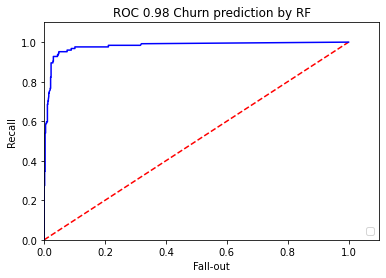

In [236]:
# Courbe ROC des données de test X et Y selon le classifieur RF
# Au mieux, le classifieur à une performance de 0.78 pour la prédiction du sexe
draw_roc_curve(rf, X_test, Y_test, "Churn prediction by RF")

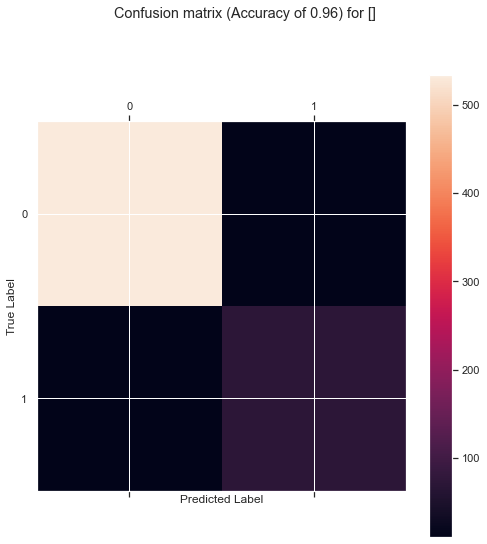

In [53]:
# Matrice de confusion des données X_test sur lesquelles on fait la prédiction et des données Y_test.
draw_confusion_matrix(Y_test, rf.predict(X_test), "")

## KNN with grid search

In [54]:
def knn_grid_search(df, Y):
    """
    Réglage des hyper-paramètres du classifieur K Nearest Neighbors
    Plusieurs hyper-paramètres sont disponibles
    L'entrainement du modèle va s'effectuer sur plusieurs paramètres
    Le best_score représentera le modèle avec les meilleurs paramètres
    """
    import sys
    from sklearn.model_selection   import GridSearchCV
    from sklearn.neighbors         import KNeighborsClassifier
    
    import pickle

    parameters = {  "n_neighbors"    : [2, 3, 5, 8 , 10]                         , 
                    "weights"         : ['uniform', 'distance']                  ,
                    "algorithm"      : ['auto', 'ball_tree', 'kd_tree', 'brute'] , 
                    "leaf_size"      : [1,3 ]                                    }
    
    
    grid_type = "knn_grid_search"
    print ("-"*30, "\n %s"%grid_type); sys.stdout.flush()
    """
        Search Grid
    """
    print (parameters);sys.stdout.flush()
    grid    = GridSearchCV(KNeighborsClassifier(), parameters, verbose=0, scoring='f1_weighted')
    try :grid.fit(df, Y)
    except Exception as e : print ("Error : [%s - 2] : %s"%(grid_type,e) ); return -1

    
    print (" best_score_ = %.2f with =  %s "%(grid.best_score_, grid.best_estimator_ ) ); sys.stdout.flush()    
    return grid

In [55]:
nb_ligne = 3000
start_time = print_time()

# Apprentissage du classifieur KNN sur X_train et Y_train (<nb_lignes> données)
knn = knn_grid_search(X_train[:nb_ligne], Y_train[:nb_ligne])

end_time = print_time()
print ("\nDuration time :", end_time - start_time)

16:43:10
------------------------------ 
 knn_grid_search
{'n_neighbors': [2, 3, 5, 8, 10], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [1, 3]}
 best_score_ = 0.86 with =  KNeighborsClassifier(leaf_size=1, n_neighbors=2, weights='distance') 
16:43:25

Duration time : 15.205899953842163


No handles with labels found to put in legend.


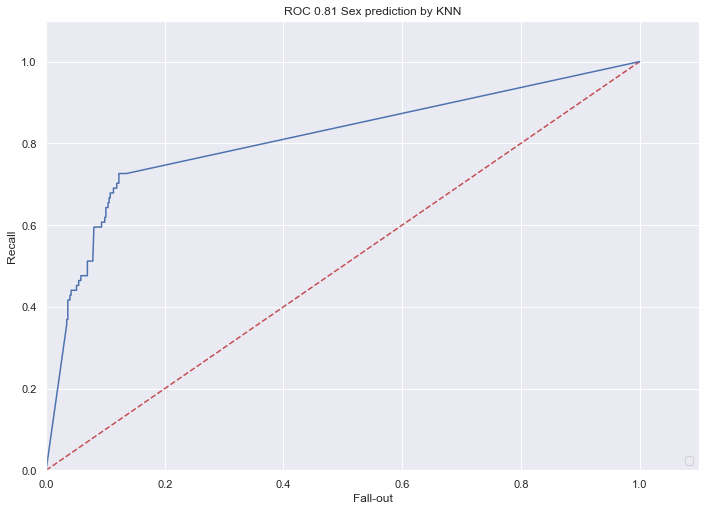

In [56]:
# Courbe ROC des données de test X et Y selon le classifieur KNN
# Au mieux, le classifieur à une performance de 0.69 pour la prédiction du sexe (mais nécessitant un temps assez important)
# Plus l'apprentissage se fait sur un nombre de données, plus l'indice de prédiction augmente.
# Pour obtenir un tel résultat, le temps nécessaire est tout de même trop important.
draw_roc_curve(knn, X_test, Y_test, "Sex prediction by KNN")

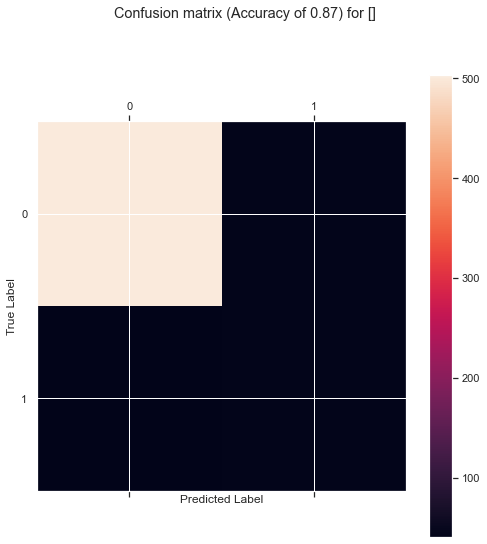

In [57]:
# Matrice de confusion des données X_test sur lesquelles on fait la prédiction et des données Y_test.
draw_confusion_matrix(Y_test, knn.predict(X_test), "") 

## CLF with grid search

In [58]:
def clf_grid_search(df, Y):
    """
    Réglage des hyper-paramètres du Classifier Gradient Boosting
    """
    import sys
    from sklearn.model_selection   import GridSearchCV
    from sklearn.neighbors         import KNeighborsClassifier
    from sklearn import ensemble
    from sklearn import datasets
    from sklearn.utils import shuffle
    from sklearn.metrics import mean_squared_error
    from sklearn.datasets import make_hastie_10_2
    from sklearn.ensemble import GradientBoostingClassifier
    
    import pickle

    parameters = {'n_estimators': 10                       ,
                  'max_depth': None                        ,
                  'min_samples_split': 2                   ,
                  'learning_rate': 0.01                    ,
                  'loss': 'ls'                             }
    
    grid_type = "clf_grid_search"
    print ("-"*30, "\n %s"%grid_type); sys.stdout.flush()
    """
        Search Grid
    """
    print (parameters);sys.stdout.flush()
    
    
    grid = GridSearchCV(GradientBoostingClassifier(), {})
    try :grid.fit(df, Y)
    except Exception as e : print ("Error : [%s - 2] : %s"%(grid_type,e) ); return -1
    print (" best_score_ = %.2f with =  %s "%(grid.best_score_, grid.best_estimator_ ) ); sys.stdout.flush()    
    return grid

In [59]:
nb_ligne = 3000
start_time = print_time()

clf = clf_grid_search(X_train[:nb_ligne], Y_train[:nb_ligne])

end_time = print_time()
print ("\nDuration time :", end_time - start_time)

16:45:06
------------------------------ 
 clf_grid_search
{'n_estimators': 10, 'max_depth': None, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}
 best_score_ = 0.94 with =  GradientBoostingClassifier() 
16:45:09

Duration time : 3.7153279781341553


No handles with labels found to put in legend.


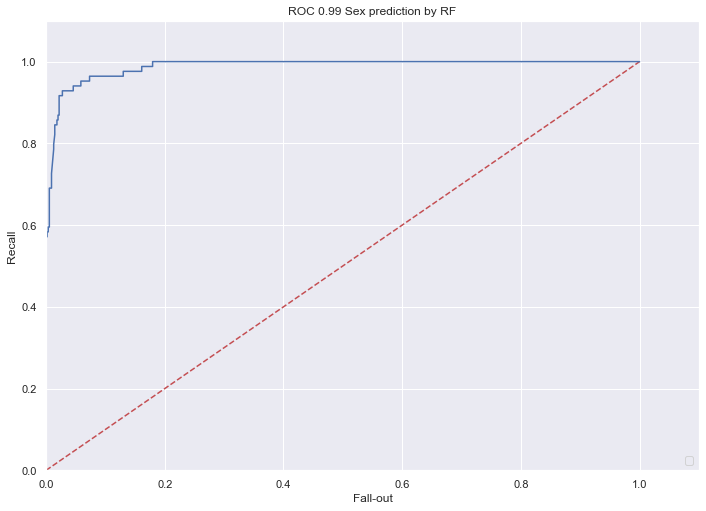

In [60]:
# Courbe ROC des données de test X et Y selon le classifieur CLF
draw_roc_curve(clf, X_test, Y_test, "Sex prediction by CLF")

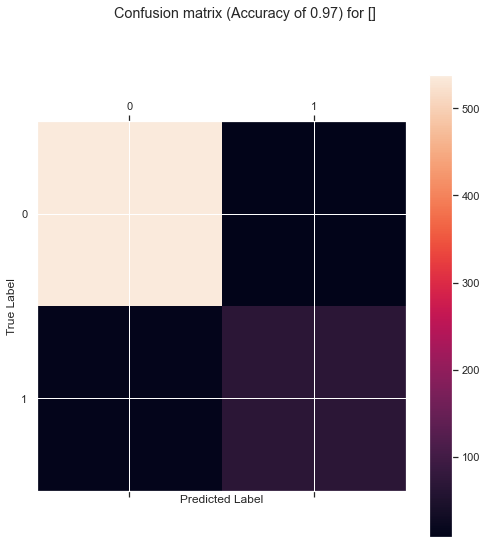

In [61]:
# Matrice de confusion des données X_test sur lesquelles on fait la prédiction et des données Y_test.
draw_confusion_matrix(Y_test, clf.predict(X_test), "")

## Tests Hyperparamètres

In [188]:
df_iranian_churn = pd.read_csv('./Customer Churn.csv', sep=',')
df_iranian_churn.rename(columns={'Call  Failure': 'Call Failure', 'Subscription  Length': 'Subscription Length','Charge  Amount': 'Charge Amount'}, inplace=True)
del df_iranian_churn["FP"]
del df_iranian_churn["FN"]

In [189]:
# X peut etre sous forme de dataframe ou numpy.ndarray
# Y peut etre sous forme de series ou numpy.ndarray
X = df_iranian_churn.iloc[:, 0:14]
y = df_iranian_churn['Churn']
X.drop(['Churn'], axis=1, inplace=True)
X.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805


In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [191]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)                 # Il ne faut fiter que sur les data d'entrainement
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)  # apply same transformation to test data

In [135]:
from sklearn.ensemble          import RandomForestClassifier
rf = RandomForestClassifier()
from sklearn.model_selection import  cross_val_score
cross_val_score(rf, X, y, n_jobs=-1)

array([0.94603175, 0.95714286, 0.93492063, 0.95873016, 0.95079365])

In [136]:
from sklearn.model_selection import GridSearchCV
parameters = {  "n_estimators"         : [ 10, 100, 200 ], 
                "min_samples_leaf"     : [  3,   1,   7 ]    }
grid = GridSearchCV(rf, parameters, n_jobs=-1)
grid.fit(X_train, y_train)
print (grid.best_score_, grid.best_estimator_)

0.9492063492063492 RandomForestClassifier()


## Etude Hyperparamètres sur tous les paramètres à partir de l'algo Random Forest

In [194]:
df_iranian_churn = pd.read_csv('./Customer Churn.csv', sep=',')
df_iranian_churn.rename(columns={'Call  Failure': 'Call Failure', 'Subscription  Length': 'Subscription Length','Charge  Amount': 'Charge Amount'}, inplace=True)
del df_iranian_churn["FP"]
del df_iranian_churn["FN"]
# X peut etre sous forme de dataframe ou numpy.ndarray
# Y peut etre sous forme de series ou numpy.ndarray

## Tests de l'algorithme Random Forest avec les meilleurs hyperparamètres en fonction du nombre de variables données en paramètres dans le dataset

On prendra alors pour l'étude tous les paramètres du dataset vu que le score augmente de manière croissante de manière analogue aux paramètres.

In [130]:
from sklearn.model_selection import GridSearchCV
parameters = {  "n_estimators"         : [ 10, 100, 200 ]           }
grid       = GridSearchCV(rf, parameters, n_jobs=-1)
grid.fit(X_train, y_train)
print (grid.best_score_, grid.best_estimator_)

0.8876984126984127 RandomForestClassifier(n_estimators=10)


In [33]:
parameters = {  "n_estimators"         : [ 10, 100, 200 ], 
                "min_samples_leaf"     : [  3,   1,   7 ]    }
grid = GridSearchCV(rf, parameters, n_jobs=-1)
grid.fit(X_train, y_train)
print (grid.best_score_, grid.best_estimator_)

0.948015873015873 RandomForestClassifier(min_samples_leaf=3, n_estimators=200)


In [35]:
parameters = {  "n_estimators"         : [ 200 ], 
                "min_samples_leaf"     : [  3],
                "criterion"            : ["gini", "entropy"] }
grid = GridSearchCV(rf, parameters, n_jobs=-1)
grid.fit(X_train, y_train)
print (grid.best_score_, grid.best_estimator_)

0.9476190476190476 RandomForestClassifier(min_samples_leaf=3, n_estimators=200)


In [40]:
parameters = {  "n_estimators"         : [200], 
                "min_samples_leaf"     : [3],
                "criterion"            : ["gini"],
                "max_features"         : ["auto"],
                "max_depth"            : [None],
                "n_jobs"               : [ -1],  
                #"class_weight"         : ["auto"],
                "warm_start"           : [False]}
grid = GridSearchCV(rf, parameters, n_jobs=-1)
grid.fit(X_train, y_train)
print (grid.best_score_, grid.best_estimator_)

0.9464285714285714 RandomForestClassifier(min_samples_leaf=3, n_estimators=200, n_jobs=-1)


In [137]:
parameters = {  "n_estimators"         : [ 200 ], 
                "min_samples_leaf"     : [  3 ],
                "n_jobs"               : [ -1]}
grid = GridSearchCV(rf, parameters, n_jobs=-1)
grid.fit(X_train, y_train)
print (grid.best_score_, grid.best_estimator_)

0.9468253968253968 RandomForestClassifier(min_samples_leaf=3, n_estimators=200, n_jobs=-1)


L'algorithme a le meilleur score avec n_estimators = 200, min_samples_leaf = 3, n_jobs = -1

On veut savoir ici le nombre de features à prendre pour notre modèle afin d'avoir la meilleure précision

In [217]:
df_iranian_churn = pd.read_csv('./Customer Churn.csv', sep=',')
df_iranian_churn.rename(columns={'Call  Failure': 'Call Failure', 'Subscription  Length': 'Subscription Length','Charge  Amount': 'Charge Amount'}, inplace=True)
del df_iranian_churn["FP"]
del df_iranian_churn["FN"]

for i in range(1, len(df_iranian_churn.columns)-1):
    X = df_iranian_churn.iloc[:, 0:i]
    y = df_iranian_churn['Churn']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    
    rf = RandomForestClassifier()

    print(cross_val_score(rf, X, y, n_jobs=-1))
    parameters = {  "n_estimators"         : [ 200 ], 
                    "min_samples_leaf"     : [  3 ],
                    "n_jobs"               : [ -1]}
    grid = GridSearchCV(rf, parameters, n_jobs=-1)
    grid.fit(X_train, y_train)
    print (grid.best_score_, grid.best_estimator_)

[0.84285714 0.84285714 0.84285714 0.84285714 0.84285714]
0.8396825396825397 RandomForestClassifier(min_samples_leaf=3, n_estimators=200, n_jobs=-1)
[0.9015873  0.88253968 0.89206349 0.89047619 0.89047619]
0.8984126984126984 RandomForestClassifier(min_samples_leaf=3, n_estimators=200, n_jobs=-1)
[0.89206349 0.86666667 0.86825397 0.88888889 0.86984127]
0.8908730158730158 RandomForestClassifier(min_samples_leaf=3, n_estimators=200, n_jobs=-1)
[0.9        0.87619048 0.88412698 0.88095238 0.87936508]
0.8980158730158732 RandomForestClassifier(min_samples_leaf=3, n_estimators=200, n_jobs=-1)
[0.92698413 0.91111111 0.8984127  0.93174603 0.92380952]
0.9166666666666666 RandomForestClassifier(min_samples_leaf=3, n_estimators=200, n_jobs=-1)
[0.93492063 0.92857143 0.8984127  0.93809524 0.93968254]
0.9261904761904761 RandomForestClassifier(min_samples_leaf=3, n_estimators=200, n_jobs=-1)
[0.93174603 0.93333333 0.8968254  0.94285714 0.93809524]
0.9341269841269841 RandomForestClassifier(min_samples_l

On constate que plus on prend des paramètres du dataset, plus la précision augmente. 
C'est pour cela que dans notre étude, nous avons choisi de prendre tous les paramètres du dataset malgré l'étude sur les corrélations avec la variable cible plus haut

### Exportation of model for API Machine Learning Model

In [239]:
import pickle
pickle.dump(model_LR, open('models/final_prediction_logistic_regression.pickle', 'wb'))
pickle.dump(model_LR_SMOTE, open('models/final_prediction_logistic_regression_SMOTE.pickle', 'wb'))
pickle.dump(model_RF, open('models/final_prediction_random_forest.pickle', 'wb'))
pickle.dump(model_KNN, open('models/final_prediction_KNN.pickle', 'wb'))
pickle.dump(model_CLF, open('models/final_prediction_CLF.pickle', 'wb'))

In [240]:
X_train.loc[0].values # Exemple de valeurs pour l'API

array([8.0000e+00, 0.0000e+00, 3.8000e+01, 0.0000e+00, 4.3700e+03,
       7.1000e+01, 5.0000e+00, 1.7000e+01, 3.0000e+00, 1.0000e+00,
       1.0000e+00, 3.0000e+01, 1.9764e+02])